# Activity Recognition Using Accelerometer Data

Author: Ben Gruher

Start date: 9/24/21

### **Part 1: Defining the business problem and value proposition**

Activity recognition is currently being used by manufacturers of smart phones and smart watches to provide accurate health and exercise information for their users. For example, when I am wearing my Apple Watch and I start to run, my watch generally notifies me that it has detected my activity and asks me if I want to start logging an outdoor run (Apple can distinguish between indoor and outdoor runs). My watch is most likely equipped with various sensors, potentially including an accelerometer, that helps it gather information and make intelligent predictions regarding my activity. 

Another possible use of activity recognition could be detecting whether an elderly person has fallen. Products such as LifeAlert have given elderly people the ability to call for help in these situations. However, these products are not effective if the user is unconscious. The ability to predict what the user is doing, even if that is laying on the floor after a fall, could be useful for detecting such accidents. Recent updates to the Apple Watch have yielded similar functionality. 

The above two use cases for activity recognition represent only the tip of the iceberg when it comes to applications of this technology. I hope to gain experience using time-series by working on a relevant business problem and active area of innovation.

### **Part 2: Loading the dataset**

The dataset is comprised of 15 individual csv files in the Data/ folder. 

From the documentation:  
Data are separated by participant  
Each file contains the following information:  
    sequential number, x acceleration, y acceleration, z acceleration, label  
Labels are codified by numbers:  
--- 1: Working at Computer  
--- 2: Standing Up, Walking and Going updown stairs  
--- 3: Standing  
--- 4: Walking  
--- 5: Going Up/Down Stairs  
--- 6: Walking and Talking with Someone  
--- 7: Talking while Standing  

We will need to read all of these csv files and concatenate them. 

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import os

In [2]:
# columns names (from documenation)
header = ['seq_num', 'x_accel', 'y_accel', 'z_accel', 'activity']

In [3]:
# class names mapped to corresponding number (from documentation)
class_names = {
    0: "Other",
    1: "Working at Computer",
    2: "Standing Up, Walking and Going updown stairs",
    3: "Standing",
    4: "Walking",
    5: "Going Up/Down Stairs",
    6: "Walking and Talking with Someone",
    7: "Talking while Standing"
}

In [4]:
df_list = list() # dataframes from each file
file_list = ['Data/' + file for file in os.listdir('Data') if file.endswith('csv')] # list of csv files in Data/ directory

In [5]:
for file in file_list:
    df_list.append(pd.read_csv(file, header=None, names=header, index_col='seq_num'))

In [6]:
data = pd.concat(df_list, axis=0).reset_index(drop=True) # concatenate all dataframes in list, adding rows to the same columns

In [7]:
data.head(5)

,x_accel,y_accel,z_accel,activity
0,2045,2326,1833,1
1,2041,2317,1832,1
2,2046,2323,1836,1
3,2046,2339,1833,1
4,2045,2335,1829,1


### **Part 3: Exploratory Data Analysis:**

In [8]:
# import necessary libraries
import matplotlib.pyplot as plt

In [9]:
# there are 1,926,896 observations, each with 4 attributes (including target attribute)
data.shape

(1926896, 4)

In [10]:
data.dtypes

x_accel     int64
y_accel     int64
z_accel     int64
activity    int64
dtype: object

In [11]:
data.head(5)

,x_accel,y_accel,z_accel,activity
0,2045,2326,1833,1
1,2041,2317,1832,1
2,2046,2323,1836,1
3,2046,2339,1833,1
4,2045,2335,1829,1


In [12]:
# check for missing values
data.isnull().sum()

x_accel     0
y_accel     0
z_accel     0
activity    0
dtype: int64

Note: if we could guaruntee that these observations were taken sequentially, we could treat them as time-series and compute a much more robust dataset. I need to check with the documenation to see if this is a valid assumption. 

**Acceleration values:**

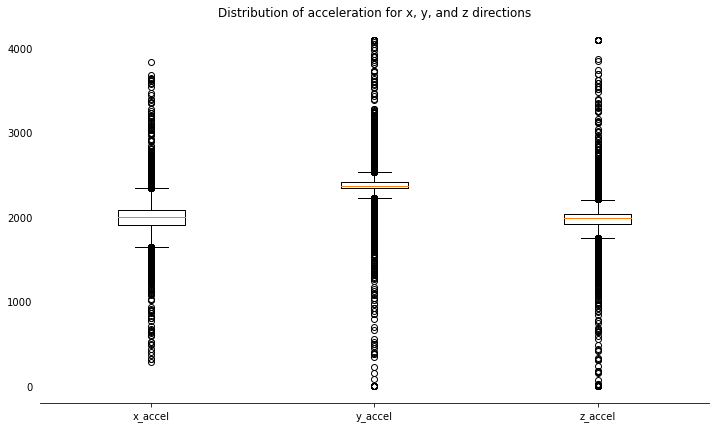

In [13]:
# explore the distributions of x_accel, y_accel, and z_accel
labels = header[1:-1]
fig, ax = plt.subplots(figsize=(12, 7))

# Remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove y-axis tick marks
ax.yaxis.set_ticks_position('none')

# Set plot title
ax.set_title('Distribution of acceleration for x, y, and z directions')

# Set species names as labels for the boxplot
boxes = [data.x_accel, data.y_accel, data.z_accel]

ax.boxplot(boxes, labels=labels)
plt.show()

Note that the data has many outliers. These outliers could either indicate misreads by the hardware or could indicate a more abrupt movement, which could help indicate the user's activity. For example, an extremely high or low y-value from the accelerometer could mean that the user is either jumping or falling. These data points should be left in the dataset, as they could be important in determining the relationship between the input features and the target variable. 

The following histograms display the distribution of the majority of the dataset for each of the features. A range is chosen to highlight the majority of the data but note that most of the outliers are not shown.

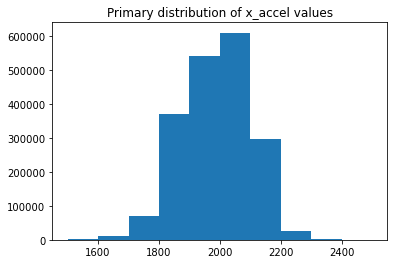

In [14]:
plt.hist(data.x_accel, range=[1500, 2500])
plt.title('Primary distribution of x_accel values')
plt.show()

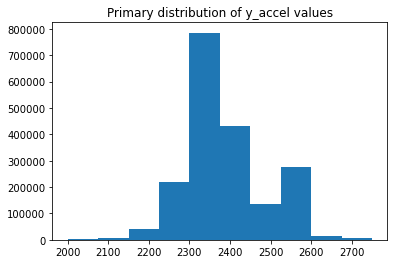

In [15]:
plt.hist(data.y_accel, range=[2000, 2750])
plt.title('Primary distribution of y_accel values')
plt.show()

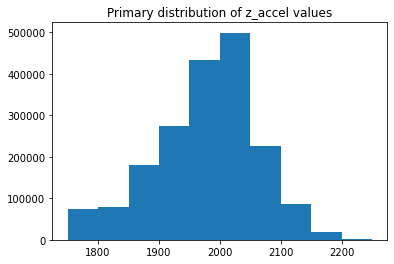

In [16]:
plt.hist(data.z_accel, range=[1750, 2250])
plt.title('Primary distribution of z_accel values')
plt.show()

**Activities:**

In [17]:
data.activity.value_counts()

1    608667
7    593563
4    357064
3    216737
5     51498
2     47878
6     47770
0      3719
Name: activity, dtype: int64

In [18]:
# inspecting rows from unexpected 0 class
data[data['activity'] == 0]

,x_accel,y_accel,z_accel,activity
122200,2064,2387,2002,0
282201,1926,2359,2026,0
329702,1991,2322,1928,0
329703,2007,2324,1919,0
329704,2030,2319,1933,0
...,...,...,...,...
1395060,2091,2541,2067,0
1522391,2065,2534,2060,0
1637093,1758,2303,2017,0
1763894,2102,2495,1939,0


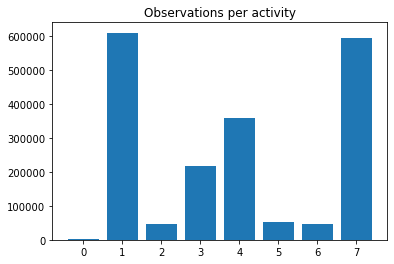

In [19]:
plt.bar(data.activity.value_counts().index, data.activity.value_counts())
plt.title('Observations per activity')
plt.show()

**Acceleration values for each activity:**

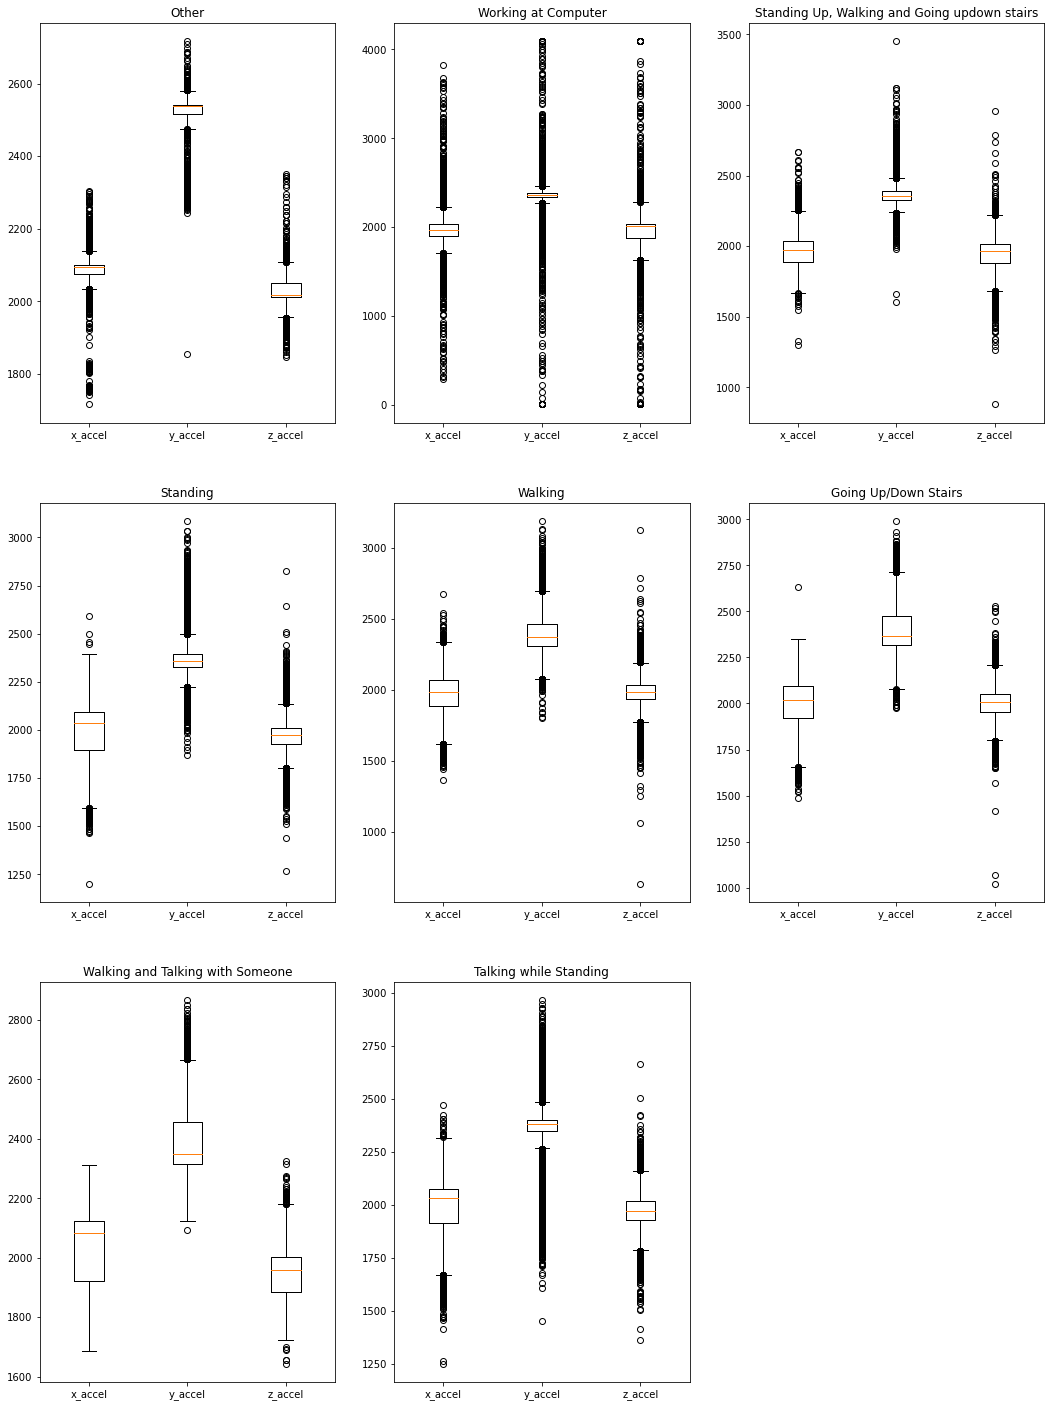

In [20]:
# explore the distributions of x_accel, y_accel, and z_accel
labels = header[1:-1]
plt.rcParams['figure.figsize'] = [18, 25]

activities = data.activity.unique()

for counter in range(len(activities)):
    plt.subplot(3, 3, counter + 1)

    plt.title(class_names[counter])

    # display data from current activity
    subset_data = data[data.activity==counter]
    
    # Set species names as labels for the boxplot
    boxes = [subset_data.x_accel, subset_data.y_accel, subset_data.z_accel]

    plt.boxplot(boxes, labels=labels)
plt.show()

In [21]:
# reset matplotlib size
%matplotlib inline

In [22]:
from mpl_toolkits import mplot3d

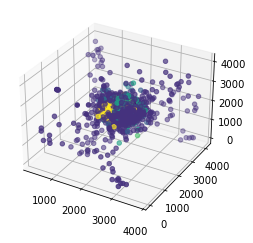

In [23]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(data.x_accel, data.y_accel, data.z_accel, c=data.activity)

**Correlation:**

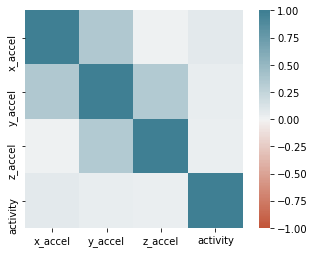

In [24]:
import seaborn as sns

corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

Based on this correlation heat map, acceleration in the X direction and acceleration in the Y direction have a fairly strong correlation. The same can be true about Y-directed acceleration and Z-directed acceleration. However, X-directed acceleration does not have a correlation with Z-directed acceleration. None of the accelerations have any significant correlation with activity but since activity is a nominal categorical variable, correlation does not make much sense here. 

In [25]:
len(data[data.activity==0])

3719

### Data Preprocessing

For this particular dataset, I did not feel that there was a whole lot of preprocessing to be done on the data. The three features (x_accel, y_accel, and z_accel) were all complete (no missing values) and basically all on the same scale (no standardization or normalization required). I decided to leave the outliers in the dataset because I felt that they might be indicative of particular activities. 

However, the documentation did not say anything about a label of zero. This could either mean that those data points were labeled in mistake or that they represented some 'other' category (as I assumed for much of the EDA process). Since this dataset and project were more focused around identifying the 7 activities mentioned on the dataset website, I decided to remove those records from the dataset. 

In [26]:
rowsToDrop = data[data.activity==0].index
data.drop(index=rowsToDrop, inplace=True, axis=0)

**Splitting train and test sets**

In [27]:
X = data[['x_accel', 'y_accel', 'z_accel']]
y = data['activity']

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)

**Balancing the classes using SMOTE:**

In [30]:
!pip install imbalanced-learn

     |████████████████████████████████| 189 kB 5.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [31]:
from imblearn.over_sampling import SMOTE

Since there is a pretty drastic class imbalance between some of the activity types, I decided to use SMOTE to generate synthetic data points in underrepresented classes. I decided to use SMOTE on only the training dataset because I wanted only real examples in my test set. This would more closely represent the unseen data that would be given to this model, should it be deployed in production. 

In [32]:
%%time

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

CPU times: user 6.91 s, sys: 86.6 ms, total: 7 s
Wall time: 7 s


In [33]:
len(X_train)

2855860

In [34]:
len(y_train)

2855860

In [35]:
y_train.value_counts()

7    407980
6    407980
5    407980
4    407980
3    407980
2    407980
1    407980
Name: activity, dtype: int64

### Test Harness

In [36]:
import time
from sklearn.metrics import accuracy_score

# Returns: timeToTrain, accuracy 
def test_algo(model):
    start = time.time()
    model.fit(X_train, y_train)
    timeToTrain = time.time() - start
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return timeToTrain, accuracy

### Baseline Model

For my baseline model, I'm going to use the sklearn logistic regression algorithm. This option is super easy to implement so it makes a good choice for a baseline model. However, I do not expect this algorithm to perform well on this dataset since it is unlikely that the underlying relationship between features and class is linear. In addition, logistic regression is not best suited for a multiclass classification problem.

Note on evaluation metric: For this project, I will be using accuracy to evaluate each model for its performance on the training dataset. While this metric is not ideal for many types of problems (specifically binary classification where one type of error costs much more than the other type of error), I believe it is a good fit for this problem. We want to be able to predict the right type of activity with very high accuracy and we will assume the cost of each misclassification is uniform amongst all the activity types. 

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
trainTime, acc = test_algo(LogisticRegression(random_state=12))
print('Algorithm: Logistic Regression')
print('Time to train (seconds): ', trainTime)
print('Accuracy: ', acc)

Algorithm: Logistic Regression
Time to train (seconds):  76.00293731689453
Accuracy:  0.07199727723513312


**Note**: the following cells demonstrate the use of several different algorithms. In order to find the best algorithm for this problem, I am taking a more experimental approach (rather than heuristic approach or simply using my favorite algorithms) so I intend to try many different algorithm types. My approach is to try several classification algorithms without optimization to determine which types of algorithms perform the best on this dataset. If an algorithm performs poorly during my preliminary training, it may suggest that this problem is not suited for that particular type of algorithm and I will most likely discard that algorithm. In subsequent sections, I will dive deeper into each algorithm and explore the hyperparameter space for each one. 

### K-Nearest Neighbors

KNN is another simple algorithm that I think will perform much better than our baseline linear model because my initial data exploration suggested that the relationship between the features and the classes was not linear. Most likely, the same activity will produce similar acceleration values so KNN should be relatively effective for this problem.

In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
trainTime, acc = test_algo(KNeighborsClassifier())
print('Algorithm: KNN')
print('Time to train (seconds): ', trainTime)
print('Accuracy: ', acc)

Algorithm: KNN
Time to train (seconds):  6.252725601196289
Accuracy:  0.611850014732553


As I predicted, KNN performed significantly better than logistic regression for this problem, most likely due to the fact that the underlying relationship is non-linear. KNN was also very quick to train, taking less than 2 seconds.

I may tweak the hyperparameters for KNN to achieve even better results after I have evaluated other non-linear options as well. 

### Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier

In [42]:
trainTime, acc = test_algo(DecisionTreeClassifier(random_state=12))
print('Algorithm: Decision Tree')
print('Time to train (seconds): ', trainTime)
print('Accuracy: ', acc)

Algorithm: Decision Tree
Time to train (seconds):  11.396514415740967
Accuracy:  0.5932476061571041


Another non-linear algorithm, decision trees, performed much better than the baseline linear model. Again, this metric could be improved through hyperparameter optimization, but we will continue to explore other non-linear algorithms in the meantime. 

### XGBoost

In [43]:
!pip install xgboost

     |████████████████████████████████| 173.5 MB 24 kB/s s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [44]:
import xgboost as xgb

In [45]:
trainTime, acc = test_algo(xgb.XGBClassifier())
print('Algorithm: XGBoost')
print('Time to train (seconds): ', trainTime)
print('Accuracy: ', acc)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:07:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Algorithm: XGBoost
Time to train (seconds):  2453.100347518921
Accuracy:  0.6550329394673277


XGBoost performed very well without any optimization. However, it did take much longer to train than many of the other algorithms. As a result, doing any sort of exhaustive grid search would be very expensive. 

### Support Vector Machine

SVM is another powerful non-linear algorithm that might perform well on this dataset. 

In [21]:
from sklearn.svm import SVC

In [49]:
# SVM takes a very long time to train so we will train our model on a subset of the data to see if it might be a good fit for this problem
subset_num_rows = int(len(X_train) / 100)
X_train_subset = X_train.sample(subset_num_rows)
y_train_subset = y_train[X_train_subset.index]

In [50]:
len(X_train_subset)

28558

In [24]:
%%time

svm = SVC(random_state=12)

svm.fit(X_train_subset, y_train_subset)
predictions = svm.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print('Algorithm: SVM')
print('Accuracy: ', accuracy)

Algorithm: SVM
Accuracy:  0.5327511742711325
CPU times: user 24min 21s, sys: 412 ms, total: 24min 22s
Wall time: 24min 23s


### Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
%%time
# also training Random Forest on a subset of the data to speed up model training

rfc = RandomForestClassifier() 

rfc.fit(X_train_subset, y_train_subset)
predictions = rfc.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

CPU times: user 19.7 s, sys: 1.19 s, total: 20.9 s
Wall time: 21 s


In [53]:
print('Algorithm: Random Forest')
print('Accuracy: ', accuracy)

Algorithm: Random Forest
Accuracy:  0.6143663662906583


### Hyperparameter Optimization

In [54]:
from sklearn.model_selection import GridSearchCV

**KNN Optimization**

In [55]:
%%time

knn_k = []
knn_acc = []
for k in range(2, 100, 10):
    trainTime, acc = test_algo(KNeighborsClassifier(n_neighbors=k))
    knn_k.append(k)
    knn_acc.append(acc)

CPU times: user 14min 17s, sys: 10.1 s, total: 14min 27s
Wall time: 14min 28s


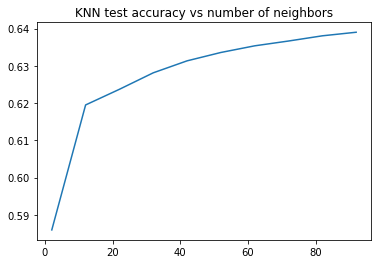

In [56]:
plt.plot(knn_k, knn_acc)
plt.title('KNN test accuracy vs number of neighbors')
plt.show()

**Decision Tree Optimization**

In [57]:
dt_params = {'max_depth': [None, 2, 4, 6]}
dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=12), dt_params)

In [58]:
%%time

dt_gs.fit(X_train, y_train)

CPU times: user 2min 38s, sys: 4.15 s, total: 2min 42s
Wall time: 2min 42s


GridSearchCV(estimator=DecisionTreeClassifier(random_state=12),
             param_grid={'max_depth': [None, 2, 4, 6]})

In [59]:
print(dt_gs.best_params_) 

{'max_depth': None}


In [60]:
predictions = dt_gs.predict(X_test)
dt_accuracy = accuracy_score(y_test, predictions)
print('Accuracy: ', dt_accuracy)

Accuracy:  0.5932476061571041


We did not see much improvement while optimizing the hyperparameters of the decision tree algorithm. 

**Random Forest Optimization**

In [61]:
rf_params = {'max_depth': range(2, 50), 'n_estimators': range(50, 300), 'min_samples_leaf': range(1, 10), 'min_samples_split': range(2, 20)}

In [62]:
# we will use random search instead of grid search to quickly search a larger hyperparameter space
from sklearn.model_selection import RandomizedSearchCV

In [63]:
rf_rs = RandomizedSearchCV(RandomForestClassifier(), rf_params, random_state=12, n_iter=50, cv=3)

In [64]:
%%time

rf_rs.fit(X_train_subset, y_train_subset) # training on subset of data to speed up model training

CPU times: user 13min 4s, sys: 548 ms, total: 13min 4s
Wall time: 13min 5s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': range(2, 50),
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 20),
                                        'n_estimators': range(50, 300)},
                   random_state=12)

In [65]:
print(rf_rs.best_params_)

{'n_estimators': 164, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 34}


In [66]:
predictions = rf_rs.predict(X_test)
rf_acc = accuracy_score(y_test, predictions)
print('Accuracy: ', rf_acc)

Accuracy:  0.6333689960907525


**XGBoost Optimization**

In [63]:
xgboost_params = {'max_depth': [2, 4, 6], 'n_estimators': [20, 50, 100]}

In [ ]:
%%time

# warning: this cell takes multiple hours to execute
# xgb_gs = GridSearchCV(xgb.XGBClassifier(), xgboost_params)
# xgb_gs.fit(X_train, y_train)

In [ ]:
print(xgb_gs.best_params_)

In [ ]:
predictions = xgb_gs.predict(X_test)
xgb_acc = accuracy_score(y_test, predictions)
print('Accuracy: ', xgb_acc)